In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
from scipy.stats import gaussian_kde

## set default matplotlib font and font size
typeface='helvetica'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import os,random
from itertools import permutations
import pandas as pd

import sys
sys.path.append('/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/visualisation_code')
import baltic_bacter as bt


In [2]:
# File path
fname = '/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/Sonnei_FullData_03052024_susbset14052024.txt'

# Reading the TSV file into a pandas DataFrame
df = pd.read_csv(fname, sep='\t')

# define which headers to use for plotting
# print all headers from 10 to 20
resitance_genes = df.columns[14:29]
# for th resistance_genes vector with entries ['ESBL', 'Quinolone', 'Other antimicrobial', 'Trimethoprim',
    #    'Quinolone/Triclosan', 'Streptomycin', 'Sulfonamide', 'Tetracycline',
    #    'Macrolide', 'Gentamicin', 'Chloramphenicol',
    #    'Beta-lactamase (not ESBL or carbapenemase)',
    #    'Beta-lactamase (unknown spectrum)', 'ESBL (AmpC type)'] 
# make a new vector with text names where Other antimicrobial is streptothricin, beta has greek sign used, not ESBL or carbapenemase is shortened and unknown spectrum is shortened
resitance_genes_text = ['lalal','ESBL', 'Quinolone', 'Streptothricin', 'Trimethoprim',
    'Quinolone/Triclosan', 'Streptomycin', 'Sulfonamide', 'Tetracycline',
    'Macrolide', 'Gentamicin', 'Chloramphenicol',
    'β-lact: non-ESBL/carb',
    'β-lact: unknwn spectr', 'ESBL (AmpC type)']



/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/Sonnei1_equal.network.tree
[]
10


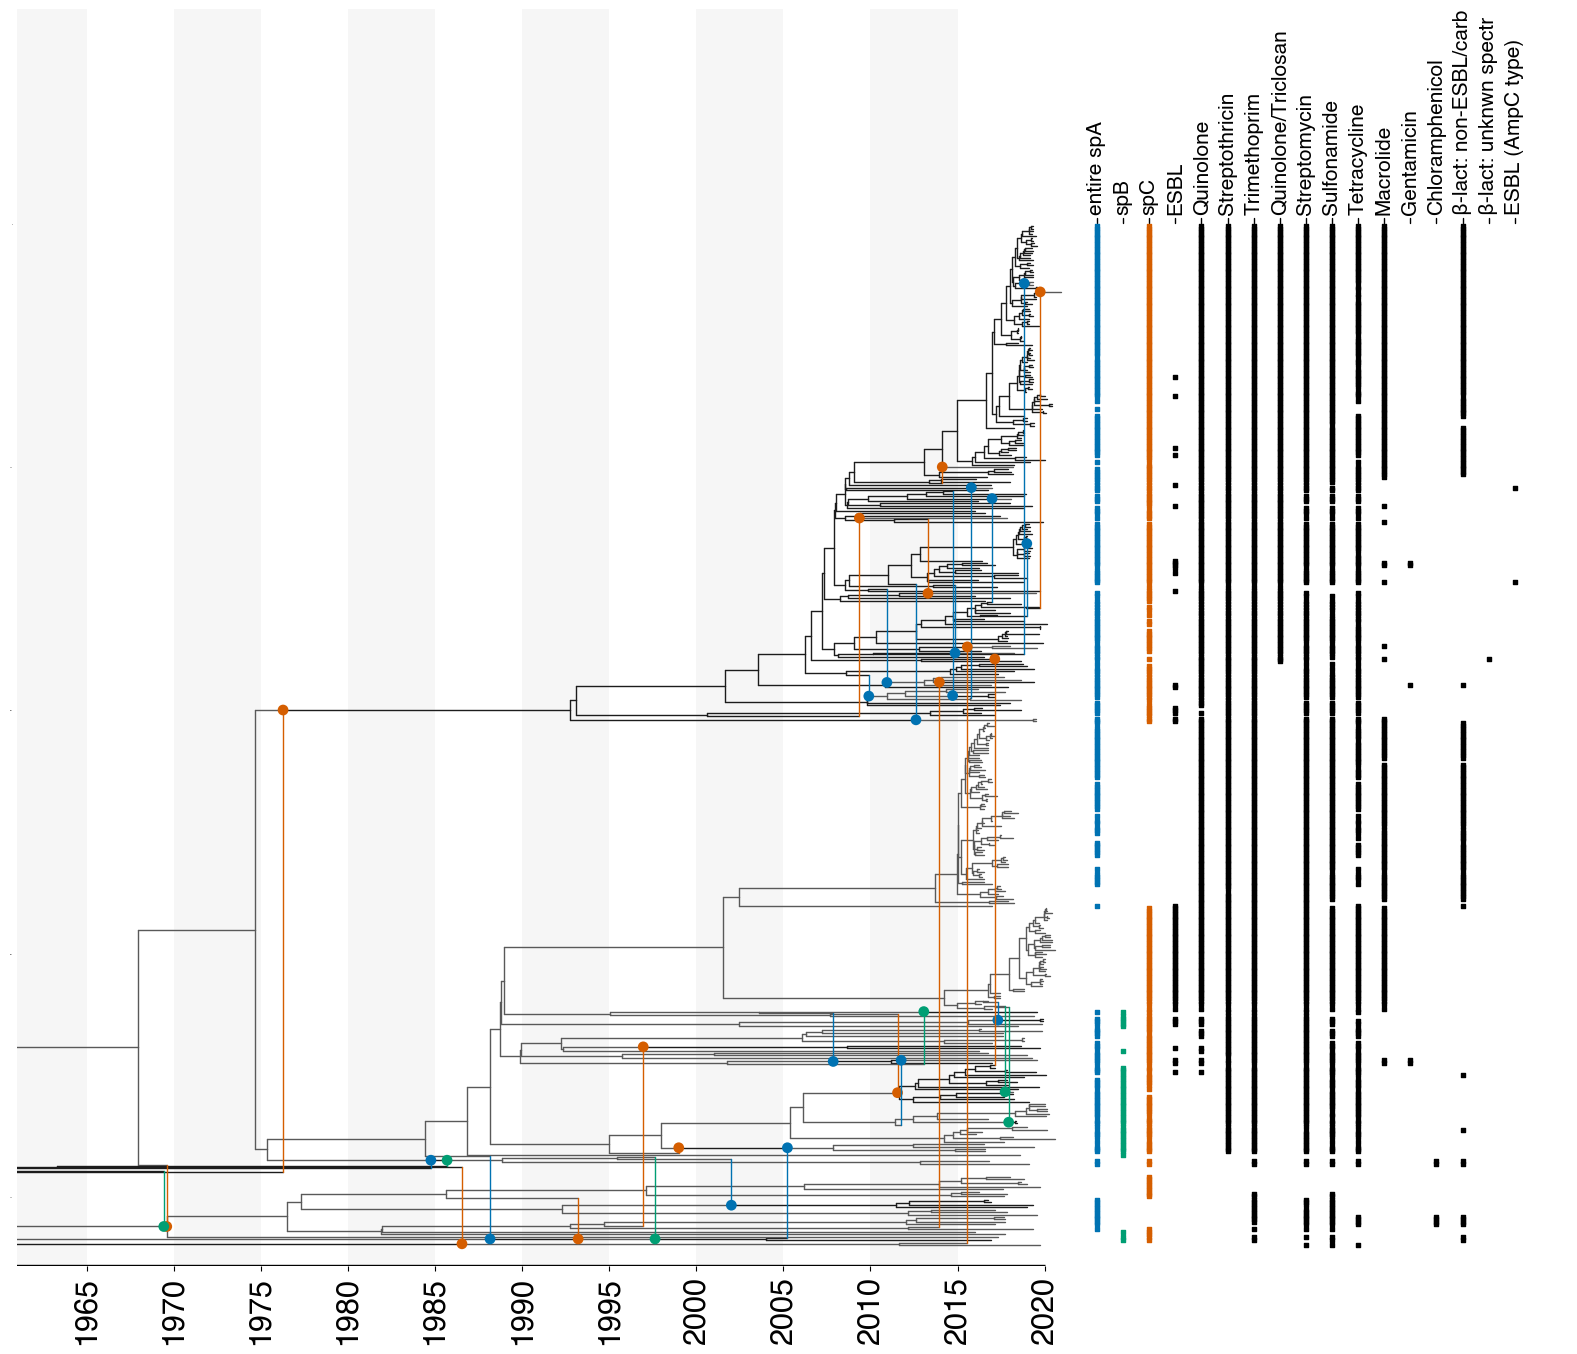

/Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei1_equal.network.pdf
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/Sonnei2_equal.network.tree
[]
10


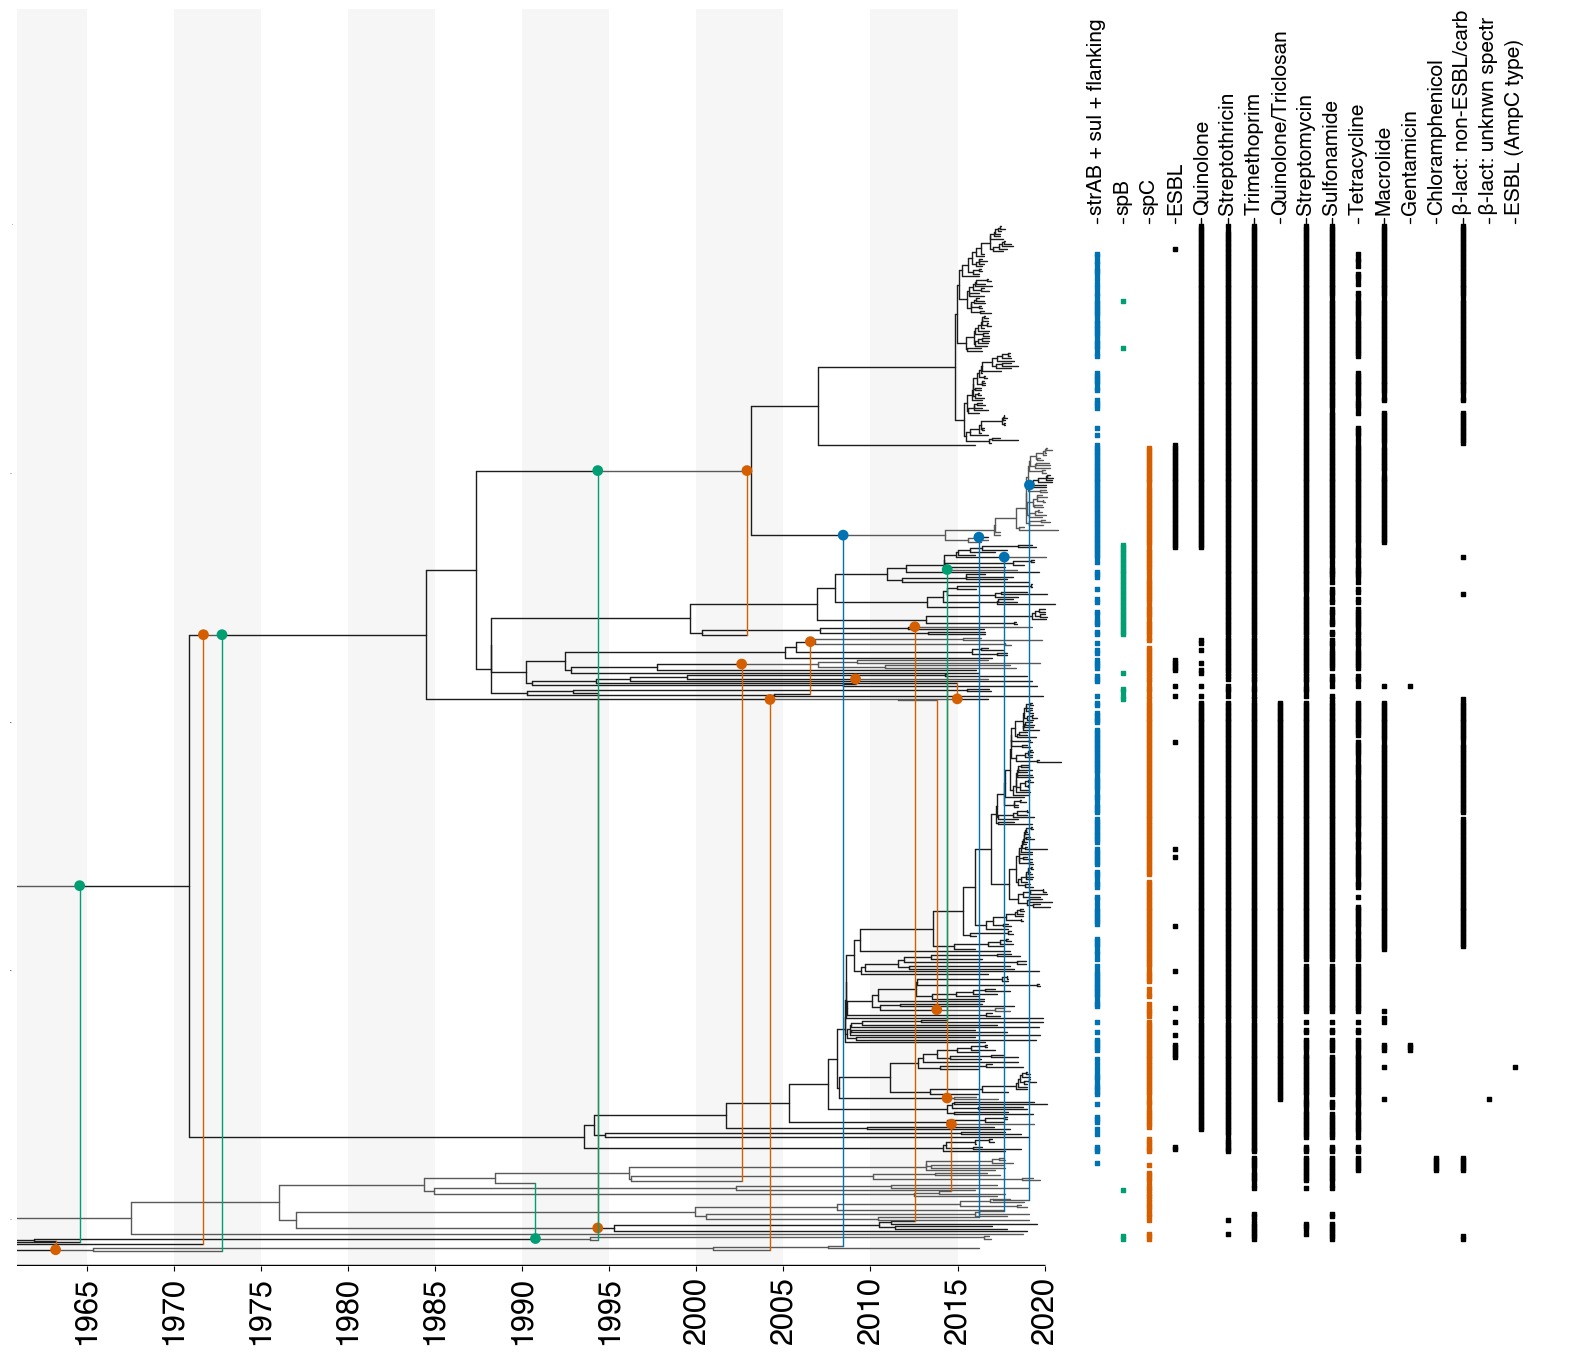

/Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei2_equal.network.pdf
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/Sonnei3_equal.network.tree
[]
10


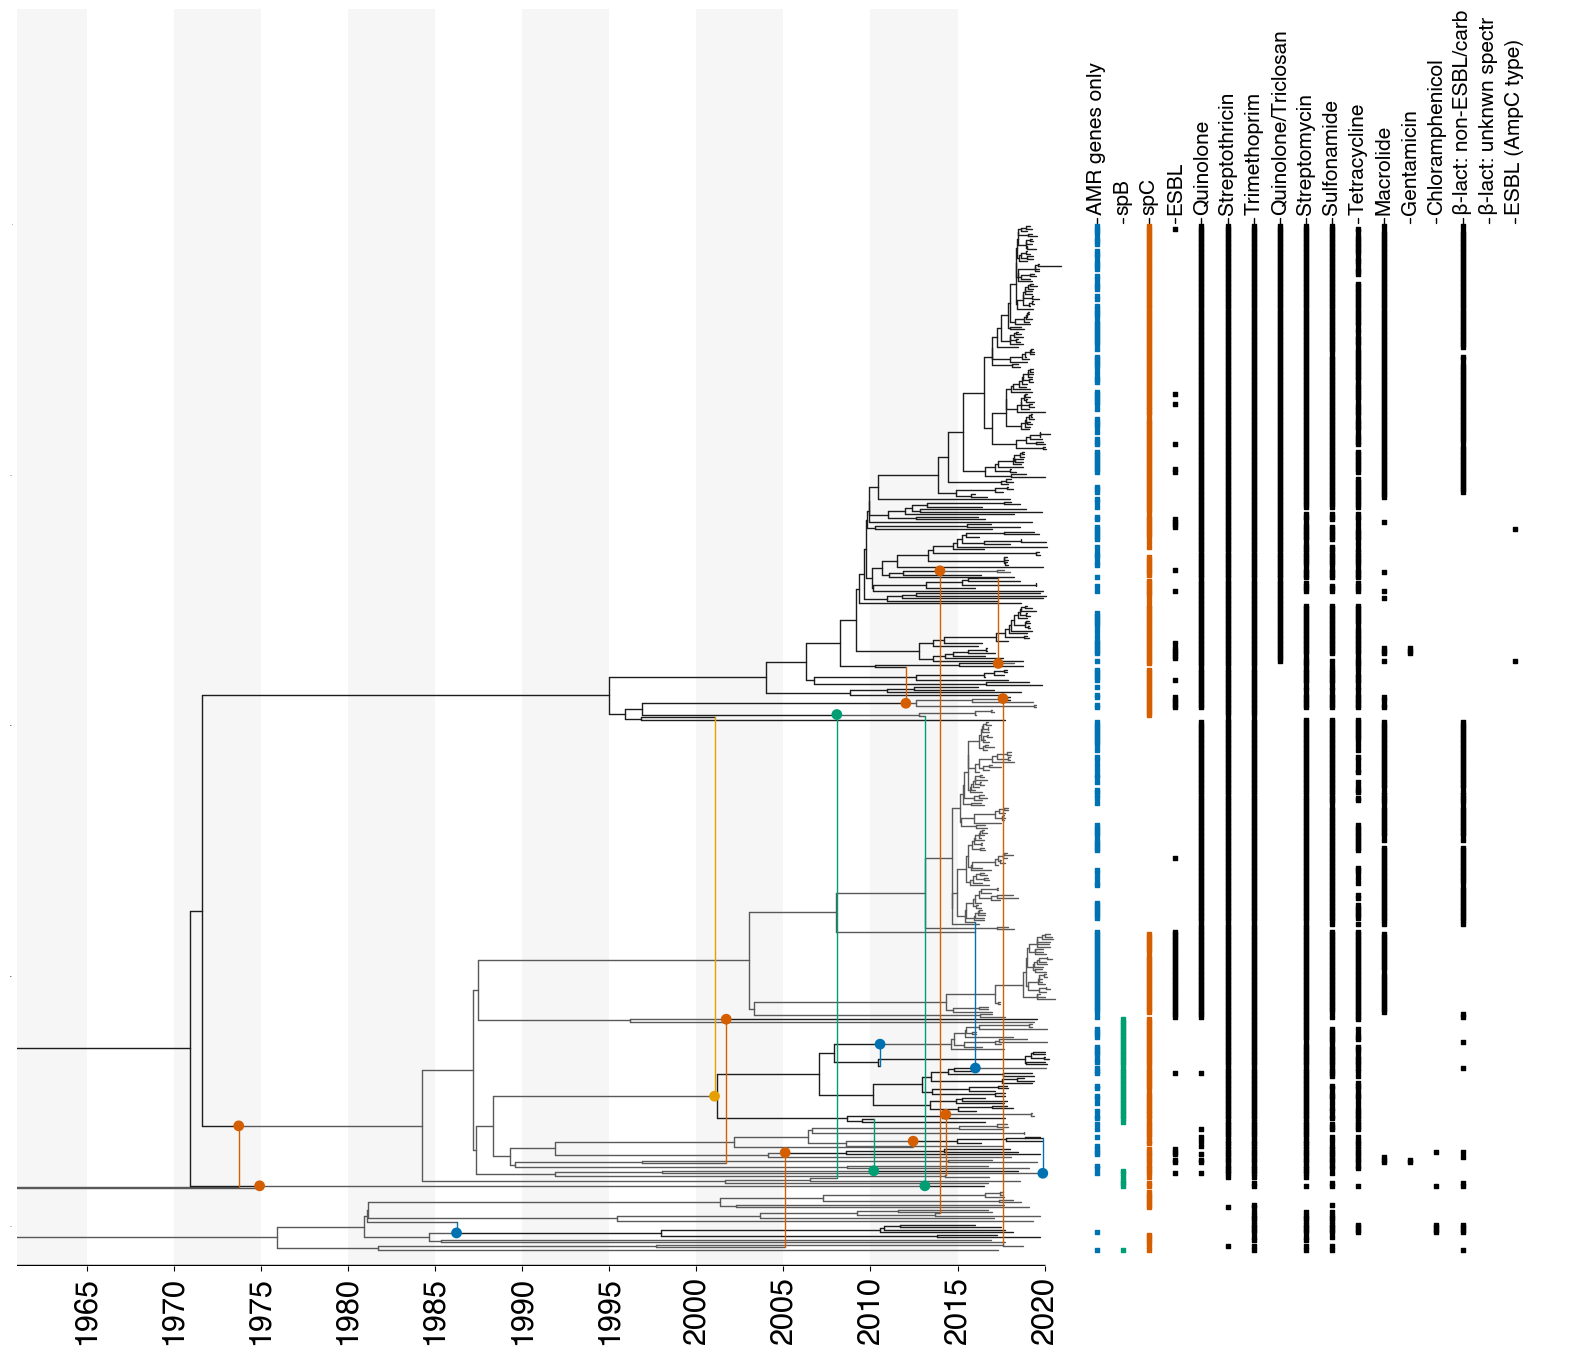

/Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei3_equal.network.pdf


In [3]:
import pandas as pd

colours={'NC_007384':(0.2981622478541206, 0.44644367598435458, 0.64719724652229571),
        'NC_007385':"#E69F00",
        'NC_009345':"#0072B2",
        'NC_009346':"#009E73",
        'NC_009347':"#D55E00"}

segments=['NC_007384','NC_007385','NC_009345','NC_009346', 'NC_009347']
segment_name=['NC_007384','NC_007385','spA','spB', 'spC']

translate={i:segments.index(x) for i,x in enumerate(sorted(segments))}

def adjust_text_position(x, y, existing_positions, delta_x=1.25, delta_y=12):
    for ex, ey in existing_positions:
        if abs(x - ex) < delta_x*2 and abs(y - ey) < delta_y:
            if (x - ex) < 0:
                xnew = ex - delta_x  # Adjust x position to the left
            else:
                xnew = ex + delta_x  # Adjust x position to the right
            # Consider breaking the loop if a single adjustment is enough
            # Otherwise, remove the break to keep checking against all existing positions
            if not any(abs(xnew - ex) < delta_x and abs(y - ey) < delta_y for ex, ey in existing_positions):
                x=xnew
                break 
    return x, y

# Track positions where text has been plotted
plotted_positions = []

zorderhighlight=3
virus=['Sonnei1_equal', 'Sonnei2_equal', 'Sonnei3_equal']
virusname=['Sonnei1_equal', 'Sonnei2_equal', 'Sonnei2_equal']

linewidth=1

spA_name = ['entire spA','strAB + sul + flanking', 'AMR genes only']
cc=0
for v in virus:
    path='/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/'
    # make file name of type 'Sonnei1_equal.network.tree'
    fname = v + '.network.tree' 

    tree_path=os.path.join(path,fname)
    print(tree_path)

    ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False,mostRecentSample="2020-12-01") ## load tree

    seg_count=0
    ll.drawTree()

    fig = plt.figure(figsize=(20, 20),facecolor='w') ## new figure
    # gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[1,4],wspace=0.1,hspace=0.1) 
    gs = gridspec.GridSpec(2,2,height_ratios=[1,6],width_ratios=[1,4],wspace=0.2,hspace=0.1) 
    ax=plt.subplot(gs[1,0:],facecolor='w') ## first subplot - tree

    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines

    colour_cycle = ["#595959", "#1c1c1c"]
    # [ax.axvline(i,ls='-',color='lightgrey',lw=1,alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),1)] ## add timeline
    timewidth=5
    [ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.2,zorder = 0, ymin=0, ymax=ll.ySpan) for i in range(0,2020,2*timewidth)] ## add timeline

    for k in ll.Objects:
        k.traits['re']=0

    curr_traits_number = 0

    for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
        if hasattr(k,'contribution'): ## if branch is the result of reassortment
            # pick a number at random between 0 and len(colour_cycle) that is not == w.traits['re']
            random_number = random.randint(0, len(colour_cycle) - 1)
            while random_number == k.traits['re']:
                random_number = random.randint(0, len(colour_cycle) - 1)

            subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
            for w in subtree: ## for every branch in subtree
                w.traits['re']=random_number

                
                #w.traits['re']=w.traits['re']+1 ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)


    for k in ll.Objects: ## iterate over branches
        x=k.absoluteTime
        xp=k.parent.absoluteTime
        y=k.y

        col=colour_cycle[k.traits['re']%len(colour_cycle)] ## get colour out of colour cycle

        if isinstance(k,bt.reticulation)==False: ## if a regular branch - colour based on number of reassortments from root
            ax.plot([x,xp],[y,y],color=col,lw=linewidth,zorder=zorderhighlight,solid_capstyle='round')
        else:
            ax.plot([x,xp],[y,y],color=col,lw=linewidth,ls='-',zorder=zorderhighlight,solid_capstyle='round') ## reassortment branches are black

        if k.branchType=='node': ## if node - plot vertical bar
            left,right=k.children[-1].y,k.children[0].y  
            
            col1=colour_cycle[k.children[-1].traits['re']%len(colour_cycle)] ## get colour out of colour cycle
            col2=colour_cycle[k.children[0].traits['re']%len(colour_cycle)] ## get colour out of colour cycle
            ax.plot([x,x],[left,k.y],color=col1,lw=linewidth,zorder=zorderhighlight,solid_capstyle='round')                
            ax.plot([x,x],[k.y,right],color=col2,lw=linewidth,zorder=zorderhighlight,solid_capstyle='round')

            
        elif isinstance(k,bt.leaf): ## if actual leaf - add circle
            # ax.scatter(x,y,s=20,facecolor=col,edgecolor='none',zorder=4)
            # ax.scatter(x,y,s=40,facecolor='k',edgecolor='none',zorder=3)
            #ax.plot([x,2024],[y,y],color='grey',lw=0.1,zorder=0)                

            # plot the presence/absence of a plasmid as a square
            for i in range(2, len(segments)):
                if i in k.traits['segments']:  # Checking if segment index is in the segments trait
                    ax.scatter(2020 + i*1.5, y, s=5,marker='s',facecolor=colours[segments[i]], zorder=3)  # Corrected color name to 'black'
            # find the index for the row colum 1 that is =k.numName in df
            index = df[df['Isolate'] == k.numName].index[0]
            # loop over all resitance genes
            for i in range(1, len(resitance_genes)):
                # check if is nan
                if not pd.isna(df.iloc[index][resitance_genes[i]]):
                    ax.scatter(2020 + 6 + i*1.5, y, s=5,marker='s',facecolor='black', zorder=3)

        elif isinstance(k,bt.reticulation): ## dealing with reassortant branch
            #if posteriorCutoff(k): ## passes posterior threshold
                segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)

                c='k'
                s=60
                for i in range(len(segs)):
                    name=segments[translate[segs[i]]] ## get name of segment
                    c=colours[name] ## get appropriate colour
                    o=1/20.
                    posterior_val = round(k.traits['posterior'],2)

                    ax.plot([x+o*i,x+o*i],[y,k.target.y],color=c,lw=linewidth,ls='-',zorder=5,solid_capstyle='round') ## plot vertical lineage leaving donor and heading to recipient
                    ax.scatter(x+o*i,k.target.y,s=s,facecolor=c,edgecolor='none',zorder=5)
                    #ax.scatter(x+o*i,k.target.y,s=s,facecolor='k',edgecolor='none',zorder=5) ## plot circles
                    if posterior_val>0.5:
                        adjusted_x, adjusted_y = adjust_text_position(x+o*i-0.25, k.target.y, plotted_positions)
                        # ax.text(adjusted_x, adjusted_y, posterior_val, ha="center", va="center", clip_on=True, zorder=6, rotation=90, fontsize='x-small', 
                                # bbox=dict(facecolor='white', alpha=0.01, edgecolor='none', boxstyle='round,pad=0'))
                        # plotted_positions.append((adjusted_x, adjusted_y))


    height = [-9, -6, -3]
    for i in range(2, len(segments)):
        # define height as the modulo of i divided by 3
        height = (i-1) % 3  * 5 + 3
        ax.plot([2020 + i*1.5, 2020 + i*1.5], [-0.25,-2.25], color='k', lw=1, solid_capstyle='round')
        if i==2:
            # use spA_name for the first segment, depending on c
            ax.text(2020 + i*1.5, -4, spA_name[cc], ha="center", va="bottom", clip_on=True, fontsize=15, rotation=90)
        else:
            ax.text(2020 +  i*1.5, -4, segment_name[i], ha="center", va="bottom", clip_on=True, fontsize=15, rotation=90)

    # add the resistance genes
    for i in range(1, len(resitance_genes)):
        ax.plot([2020 + 6 + i*1.5, 2020 + 6 + i*1.5], [-0.25,-2.25], color='k', lw=1, solid_capstyle='round')

        ax.text(2020 + 6 + i*1.5, -4, resitance_genes_text[i], ha="center", va="bottom", clip_on=True, fontsize=15, rotation=90)

    x_ticks = np.arange(1960, 2021, 5)  # Example: Ticks every 5 years from 1971 to 2027
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=90, ha="center")

                        
    ax.tick_params(axis='y',size=0,labelsize=0)
    # ax.tick_params(axis='x', size=0, labelsize=28, rotation=90)
    ax.set_ylim(ll.ySpan*1.01,-ll.ySpan*0.208)
    ax.set_xlim(1961,2050)

    ax.spines['bottom'].set_visible(False)

    # Draw a custom horizontal line for the x-axis between 1970 and 2020
    ax.hlines(y=ll.ySpan*1.009, xmin=1950, xmax=2020, colors='k', linestyles='-', lw=1)


    plt.show()

    figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/' + v + '.network.pdf'
    print(figname)
    fig.savefig(figname, bbox_inches='tight')
    plt.close(fig)
    cc+=1


0
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/SonFlex_equal.network.tree
[]
10
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/SonFlex_equal.network.mapped.tree
[]
10
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


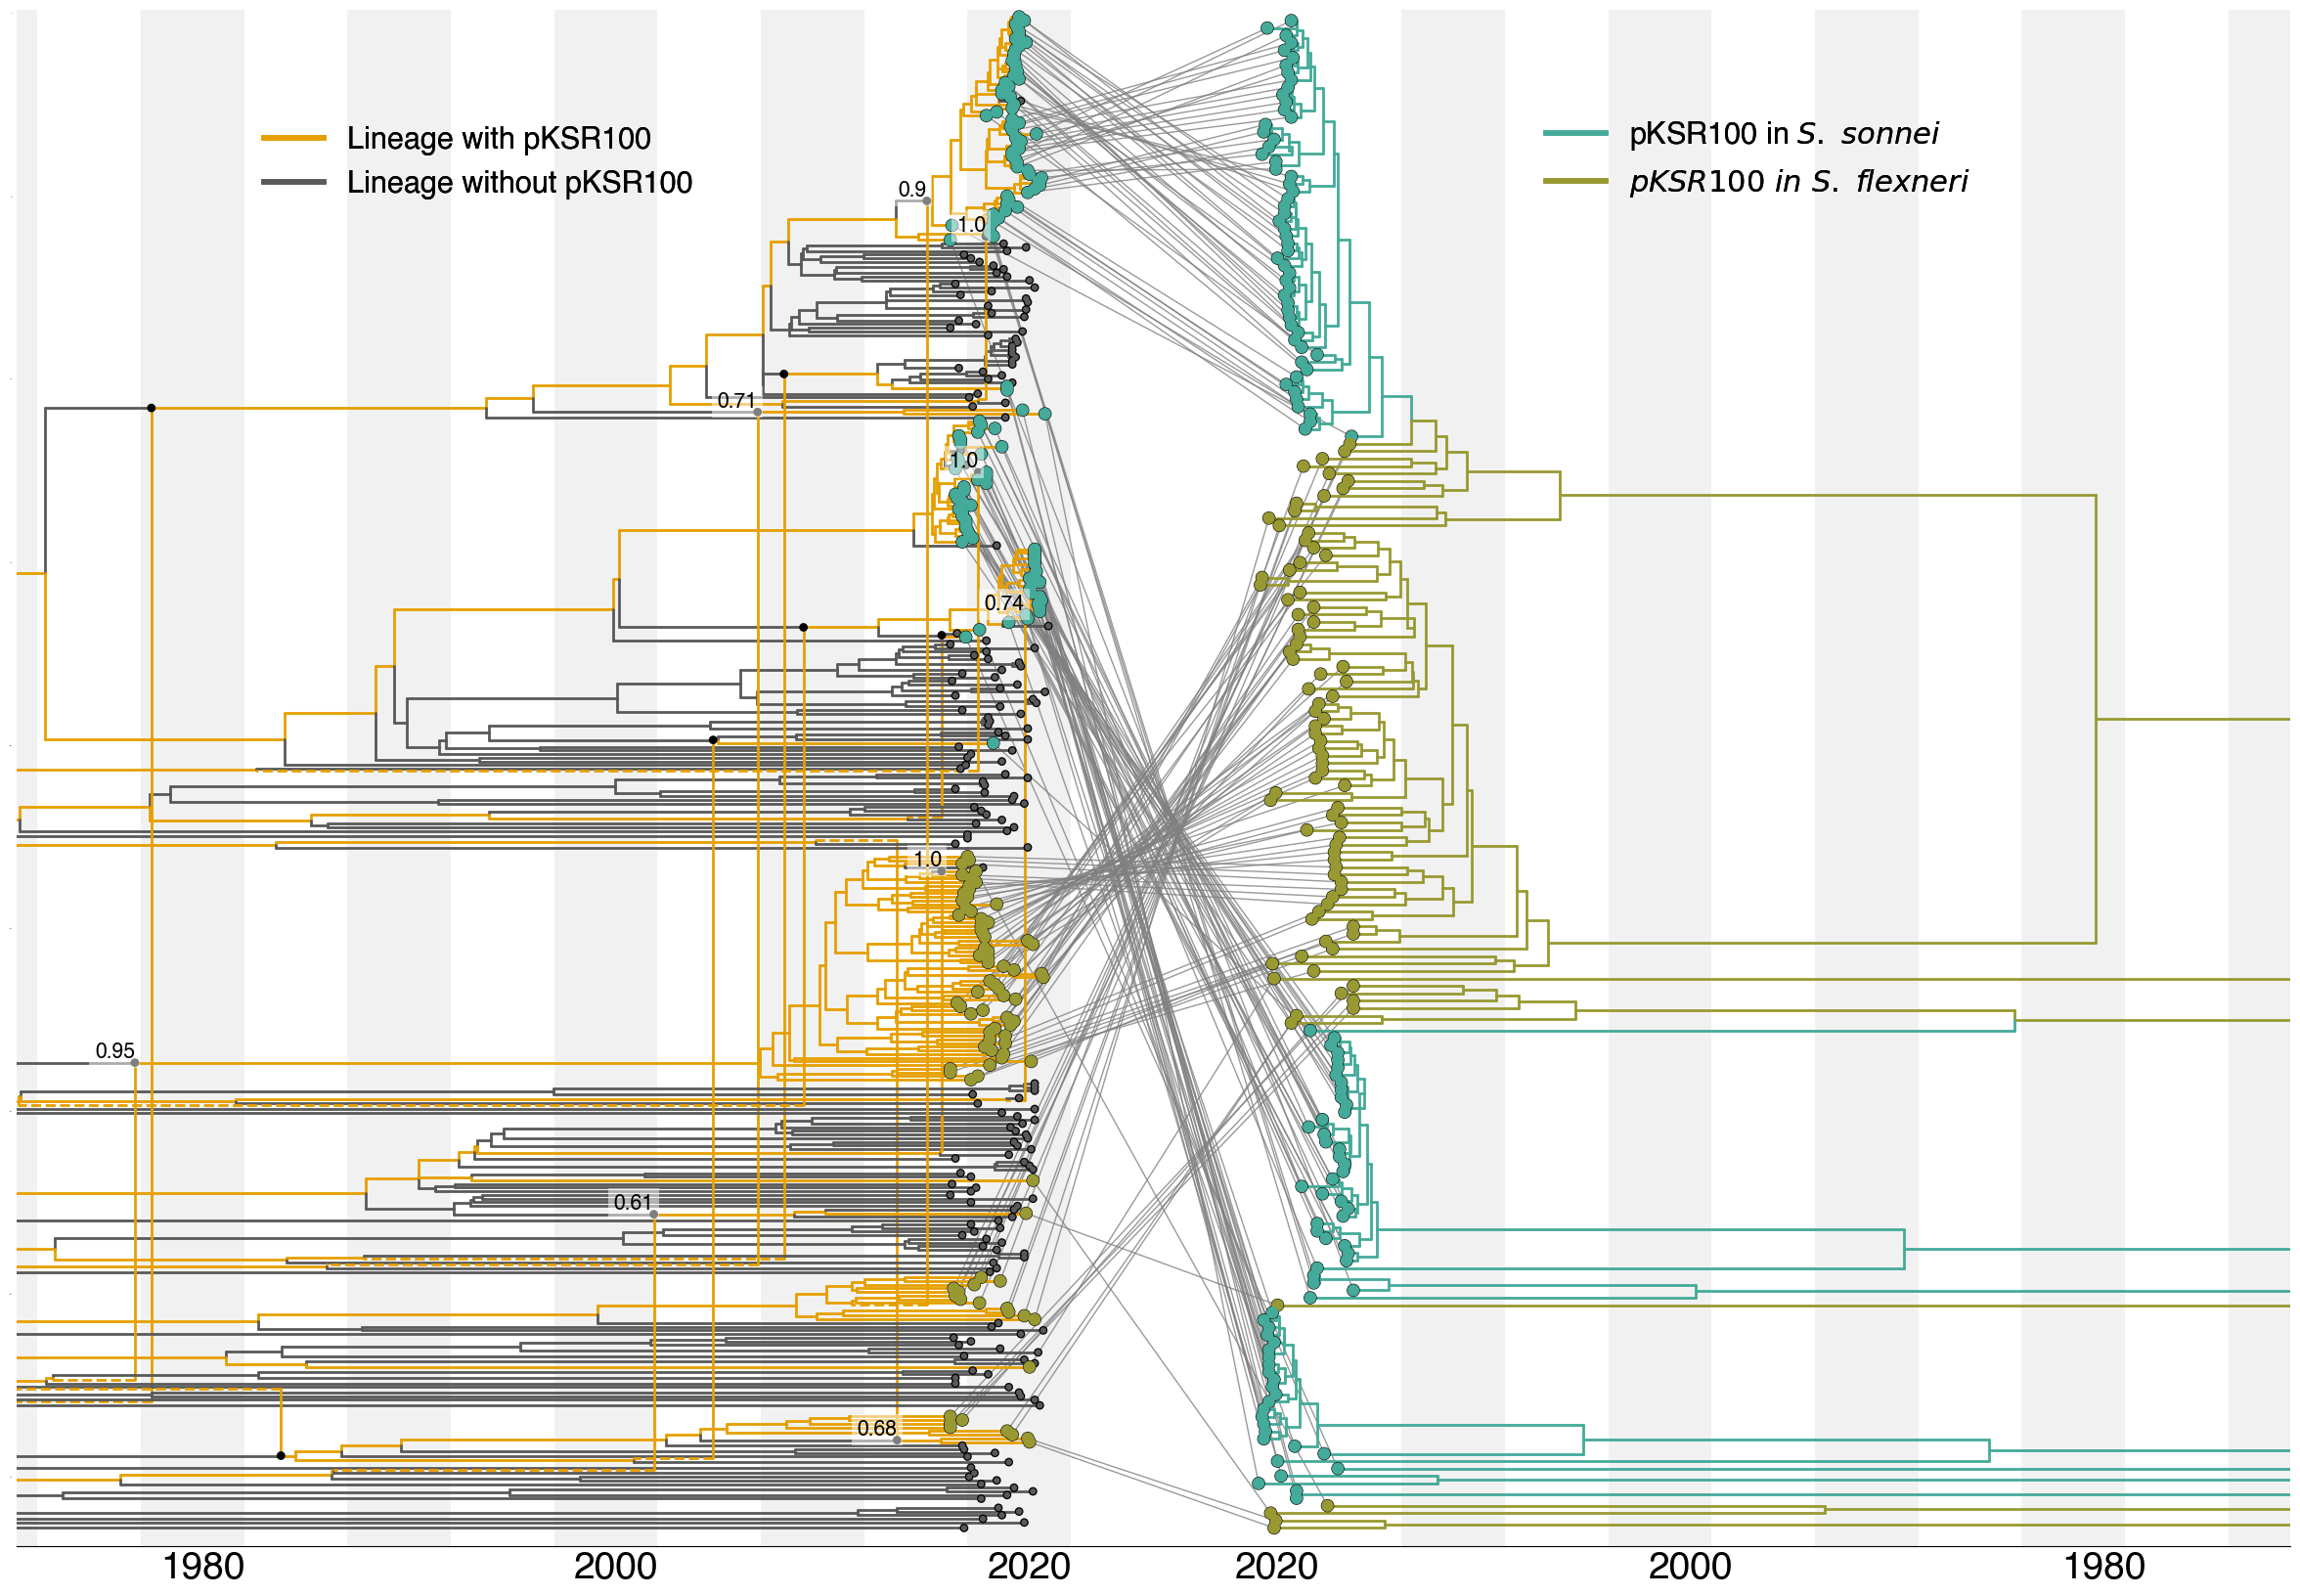

In [4]:
from matplotlib.lines import Line2D


segments=['NC_007384','network.mapped']
translate={i:segments.index(x) for i,x in enumerate(sorted(segments))}

colourSwitches=["#595959", "#595959"]

colours={'NC_007384':(0, 0, 0),
        'network.mapped':'#E69F00',
        'son':"#44AA99",
        'flex':"#999933",
        'NS':(0.8, 0.7552941176470589, 0.5929411764705883)}

virus=['SonFlex_equal']
virusname=['SonFlex_equal']

leaf_coords = dict()


# Create custom legend entries
legend_elements = [
    Line2D([0], [0], color='#E69F00', lw=4, label='Lineage with pKSR100'),
    Line2D([0], [0], color='#595959', lw=4, label='Lineage without pKSR100')
]

legend_elements2 = [
    Line2D([0], [0], color='#44AA99', lw=4, label=r'pKSR100 in $\mathit{S.\ sonnei}$'),
    Line2D([0], [0], color='#999933', lw=4, label=r'$\mathit{pKSR100\ in\ S.\ flexneri}$')
]


for v in range(len(virus)):
    print(v)

    path='/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/'
    
    
    fname= virusname[v] + '.network.tree'

    tree_path=os.path.join(path,fname)
       
    seg='network.mapped'
    
    print(tree_path)

    ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False,mostRecentSample="2020-12-01") ## load tree
    
    seg_count=1
    ll.drawTree()

    fig = plt.figure(figsize=(30, 25),facecolor='w') ## new figure
    # gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[1,4],wspace=0.1,hspace=0.1) 
    gs = gridspec.GridSpec(2,2,height_ratios=[1,6],width_ratios=[1,4],wspace=0.2,hspace=0.1) 

    ax=plt.subplot(gs[1,0:],facecolor='w') ## first subplot - tree
    
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines
    # [ax.axvline(i,ls='-',color='lightgrey',lw=1,alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),1)] ## add timeline
    timewidth=5
    [ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.3,zorder=0) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),2*timewidth)] ## add timeline


    yvals = list()

    for k in ll.Objects:
        k.traits['re']=0

    for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
        if hasattr(k,'contribution'): ## if branch is the result of reassortment
            subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
            for w in subtree: ## for every branch in subtree
                #if posteriorCutoff(k.contribution): ## if it's a branch that passes a posterior threshold
                    w.traits['re']=max([w.traits['re']+1,k.contribution.traits['re']+1]) ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)
                    

    linewidth=2
    for k in ll.Objects: ## iterate over branches
        x=k.absoluteTime
        xp=k.parent.absoluteTime
        y=k.y
        if k.traits['seg'+str(seg_count)]=="true":
            col=colours[seg]
        else:
            col=colourSwitches[1]

        if isinstance(k,bt.reticulation)==False: ## if a regular branch - colour based on number of reassortments from root
            ax.plot([x,xp],[y,y],color=col,lw=linewidth,zorder=1,solid_capstyle='round')
        else:
            ax.plot([x,xp],[y,y],color=col,lw=linewidth,ls='--',zorder=1,solid_capstyle='round') ## reassortment branches are black

        if k.branchType=='node': ## if node - plot vertical bar
            left,right=k.children[-1].y,k.children[0].y

            if k.children[-1].traits['seg'+str(seg_count)]=="true":
                col1=colours[seg]
            else:
                col1=colourSwitches[1]


            if k.children[0].traits['seg'+str(seg_count)]=="true":
                col2=colours[seg]
            else:
                col2=colourSwitches[1]

            ax.plot([x,x],[left,k.y],color=col1,lw=linewidth,zorder=1,solid_capstyle='round')                
            ax.plot([x,x],[k.y,right],color=col2,lw=linewidth,zorder=1,solid_capstyle='round')


        elif isinstance(k,bt.leaf): ## if actual leaf - add circle
            leaf_coords[k.numName] = [x,y]
            yvals.append(y) 
            
            ax.scatter(x,y,s=20,facecolor=col,edgecolor='none',zorder=4)
            ax.scatter(x,y,s=40,facecolor='k',edgecolor='none',zorder=3)

        elif isinstance(k,bt.reticulation): ## dealing with reassortant branch
            #if posteriorCutoff(k): ## passes posterior threshold
                segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)

                c='k'
                s=20
                for i in range(len(segs)):
                    name=segments[translate[segs[i]]] ## get name of segment
                    c=colours[name] ## get appropriate colour
                    o=1/20.
                    posterior_val = round(k.traits['posterior'],2)

                    ax.plot([x+o*i,x+o*i],[y,k.target.y],color=col,lw=linewidth,ls='-',zorder=1,solid_capstyle='round') ## plot vertical lineage leaving donor and heading to recipient
                    ax.scatter(x+o*i,k.target.y,s=s,facecolor='k',edgecolor='none',zorder=3) ## plot circles
                    ax.scatter(x+o*i,k.target.y,s=s*2,facecolor='k',edgecolor='none',zorder=2)
                    if k.traits['seg'+str(seg_count)]=="true" and posterior_val>0.5:
                        ax.text(x+o*i, k.target.y, posterior_val,ha="right", va="bottom",clip_on=True,
                                fontsize='x-small', zorder=10,bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))


    ax.tick_params(axis='y',size=0,labelsize=0)
    ax.tick_params(axis='x',size=0,labelsize=28)

    ylim_value = ll.ySpan

        
        
    # plot the mapped plasmid tree
    fname= virusname[v] + '.network.mapped.tree'
    tree_path=os.path.join(path,fname)
       
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines
    # [ax.axvline(i,ls='-',color='lightgrey',lw=1,alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),1)] ## add timeline
    timewidth=-5    
    adjustedroot = ll.root.absoluteTime *-1 + 2021*2 +10     
    [ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.3,zorder=0) for i in range(int(adjustedroot-1),int(adjustedroot-ll.treeHeight+1),2*timewidth)] ## add timeline    
    ax.tick_params(axis='y',size=0,labelsize=0)
    ax.tick_params(axis='x',size=0,labelsize=28)   
    ax.set_ylim(max(yvals)+5,-1)
    ax.set_xlim(1971,2081)    
    xtickvals = [1980, 2000, 2020, 2032, 2052,2072]    
    ax.set_xticks(xtickvals)
    ax.set_xticklabels([1980, 2000, 2020, 2020, 2000, 1980])
    
    
    figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/SonFlex.tangletree_part1.pdf'
    fig.savefig(figname, bbox_inches='tight')
    
    print(tree_path)
    ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False,mostRecentSample="2020-12-01") ## load tree
    
    ll.drawTree()
    
    counter = 1;
    counterList = list()
    
    for k in ll.Objects:
        k.traits['re']=-1

    for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
        if not isinstance(k,bt.leaf) and k.parent!=None and k.parent.parent!=None and k.parent.traits['state']!=k.traits['state']:               
            counter=counter+1
            k.parent.traits['re'] = counter
            subtree=ll.traverse_tree(k,include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
            for w in subtree: ## for every branch in subtree
                w.traits['re']=w.parent.traits['re'] ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)
                if isinstance(w,bt.leaf):
                    counterList.append(counter)
                
        elif isinstance(k,bt.leaf) and k.parent.traits['state']!=k.traits['state']:
            counter=counter+1
            k.traits['re'] = counter
            counterList.append(counter)

    unicounterset = list(set(counterList))
    print(unicounterset)
                    
    clusterColourSwitches=[mpl.cm.tab20b(i) for i in unicounterset]
                    
    yscale_ratio = max(yvals)/ll.ySpan    

    for k in ll.Objects: ## iterate over branches
        x=k.absoluteTime *-1 + 2021*2 +10
        
        if k.parent.absoluteTime!=None:
            xp=k.parent.absoluteTime *-1 + 2021*2 +10
        else:
            xp=None

        y=k.y * yscale_ratio
        
        linewidth=2

        if k.traits['state']==0:
            col=colours['son']
        else:
            col=colours['flex']

        if isinstance(k,bt.reticulation)==False:
            ax.plot([x,xp], [y,y], color=col, lw=linewidth, zorder=2,solid_capstyle='round')

        if k.branchType=='node': ## if node - plot vertical bar
            left,right=k.children[-1].y,k.children[0].y

            if k.children[-1].traits['state']==0:
                col1=colours['son']
            else:
                col1=colours['flex']



            if k.children[0].traits['state']==0:
                col2=colours['son']
            else:
                col2=colours['flex']

            ax.plot([x,x],[left*yscale_ratio,k.y*yscale_ratio],color=col1,lw=linewidth,zorder=2,solid_capstyle='round')                
            ax.plot([x,x],[k.y*yscale_ratio,right*yscale_ratio],color=col2,lw=linewidth,zorder=2,solid_capstyle='round')

        elif isinstance(k,bt.leaf): ## if actual leaf - add circle
            
            vals = leaf_coords[k.name]
            
            colorind = unicounterset.index(k.traits['re'])
            
            #ax.plot([vals[0], 2022], [vals[1], vals[1]], color=col,ls=':', lw=0.5)
            #ax.plot([2021, 2031], [vals[1], y], color=col,ls=':', lw=0.5)
            ax.plot([vals[0], x], [vals[1], y], color='grey',ls='-', lw=1,zorder=0, alpha=0.8)
#            ax.plot([2029,x], [y, y], color=col,ls=':', lw=0.5)
            title_font = {'fontname':'Arial', 'size':'5'}

            if k.traits['state']==0:
                col=colours['son']
            else:
                col=colours['flex']

        
            ax.scatter(vals[0],vals[1],s=80,facecolor=col,edgecolor='none',zorder=9)
            ax.scatter(vals[0],vals[1],s=95,facecolor='k',edgecolor='none',zorder=8)

            ax.scatter(x,y,s=80,facecolor=col,edgecolor='none',zorder=4)
            ax.scatter(x,y,s=95,facecolor='k',edgecolor='none',zorder=3)

    first_legend = fig.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.2, 0.65), title='', frameon=False)
    ax.add_artist(first_legend)  # Make sure this line is here if it's not added automatically
    
    # For the second legend
    second_legend = fig.legend(handles=legend_elements2, loc='lower right', bbox_to_anchor=(0.8,0.65), title='', frameon=False)
    ax.add_artist(second_legend)  # Manually add the second legend to the axes

    plt.show()
    #figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/' + virusname[v] +'.' +seg + '.pdf'
    #fig.savefig(figname, bbox_inches='tight')
    plt.close(fig)
    seg_count=seg_count+1

    figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/SonFlex.tangletree.pdf'
    fig.savefig(figname, bbox_inches='tight')
    plt.close(fig)



[]
10


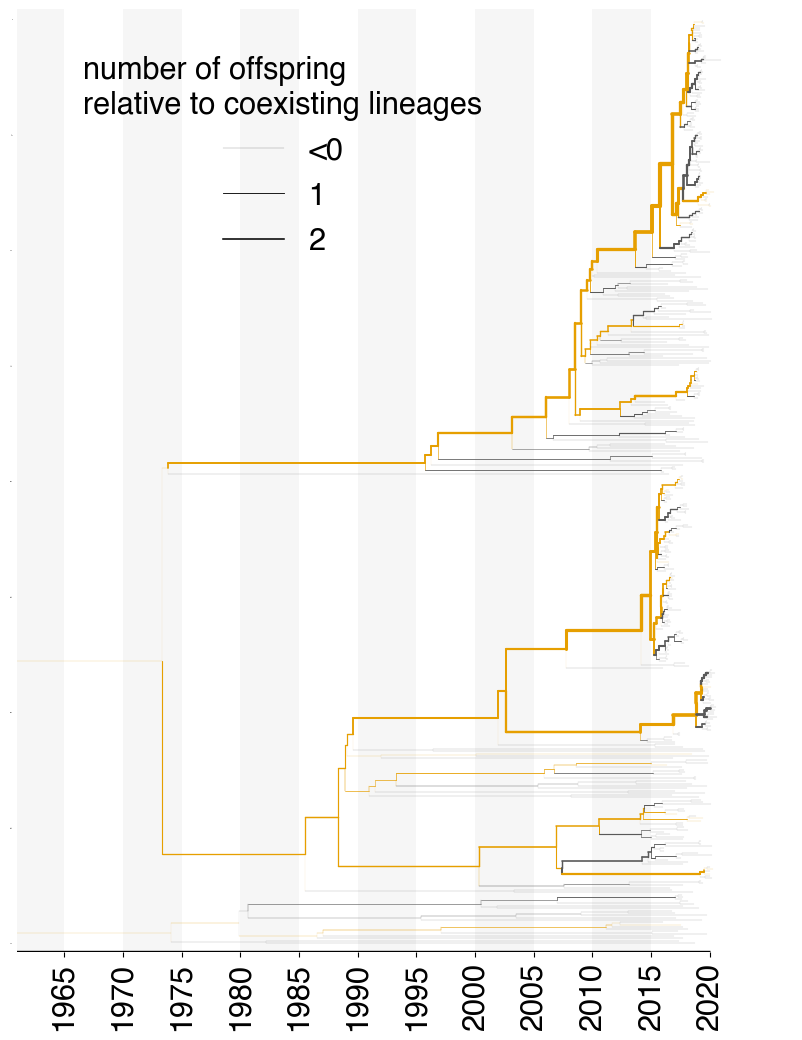

/Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei3_1_mapped.tree.pdf
[]
10


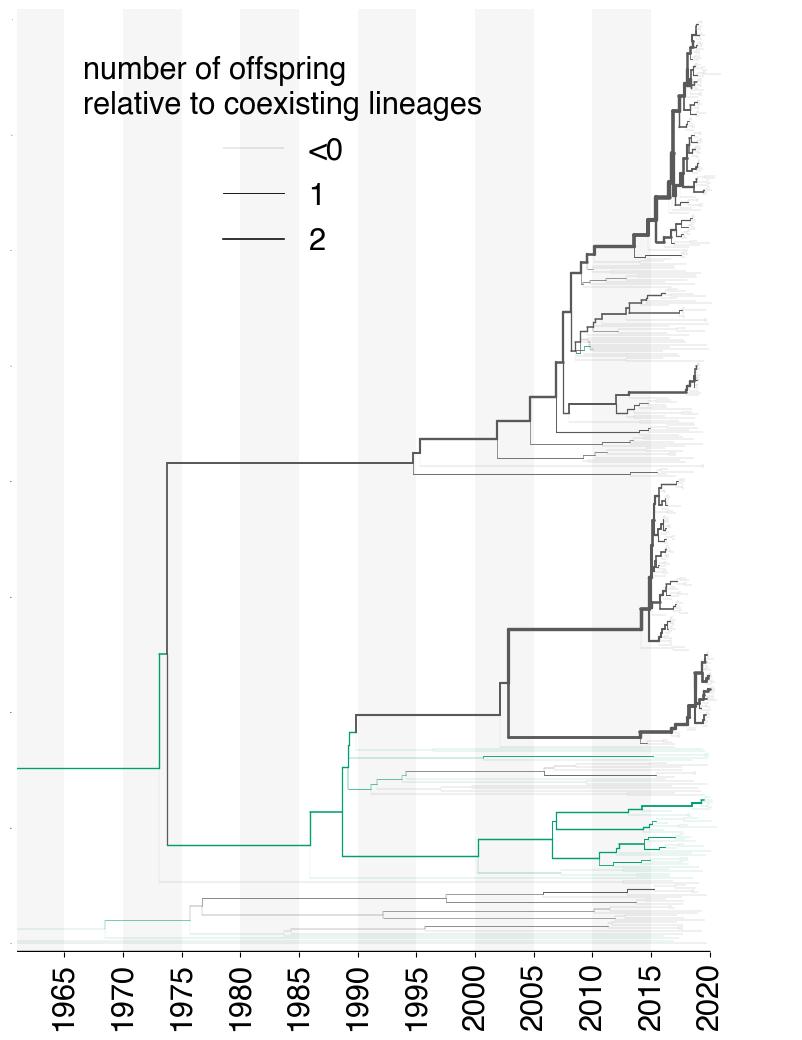

/Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei1_1_mapped.tree.pdf
[]
10


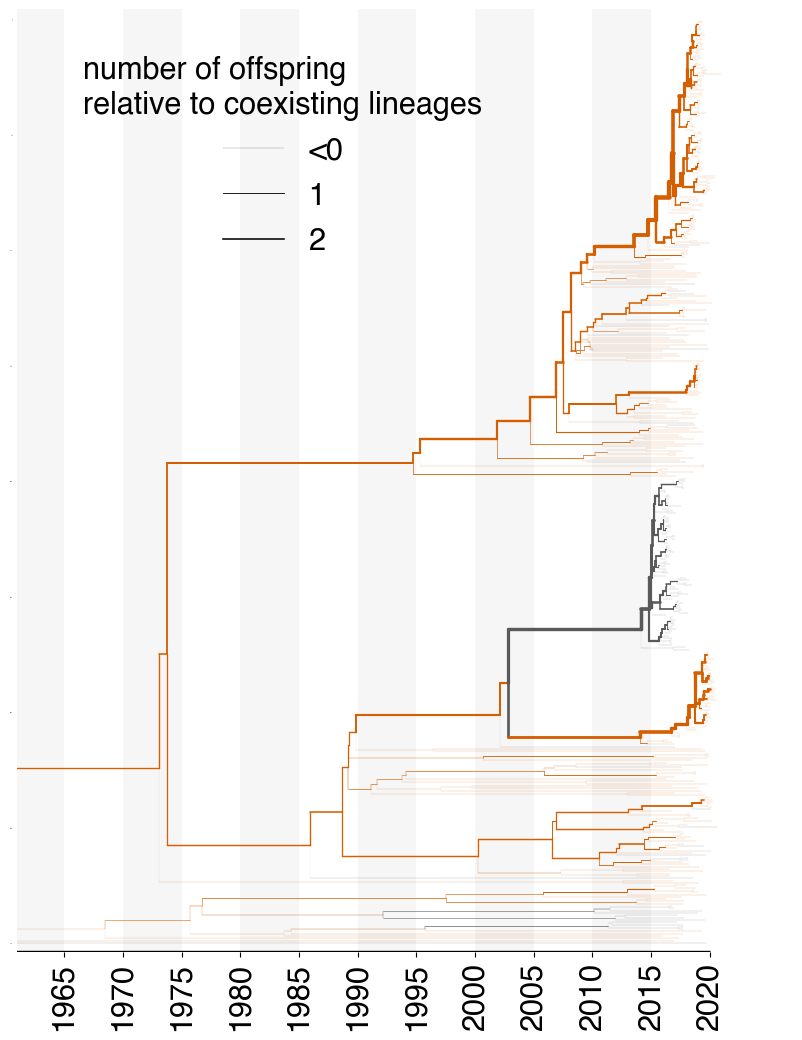

/Users/nmueller/Documents/github/Plasmids-Text/Figures/Sonnei1_1_mapped.tree.pdf
[]
10


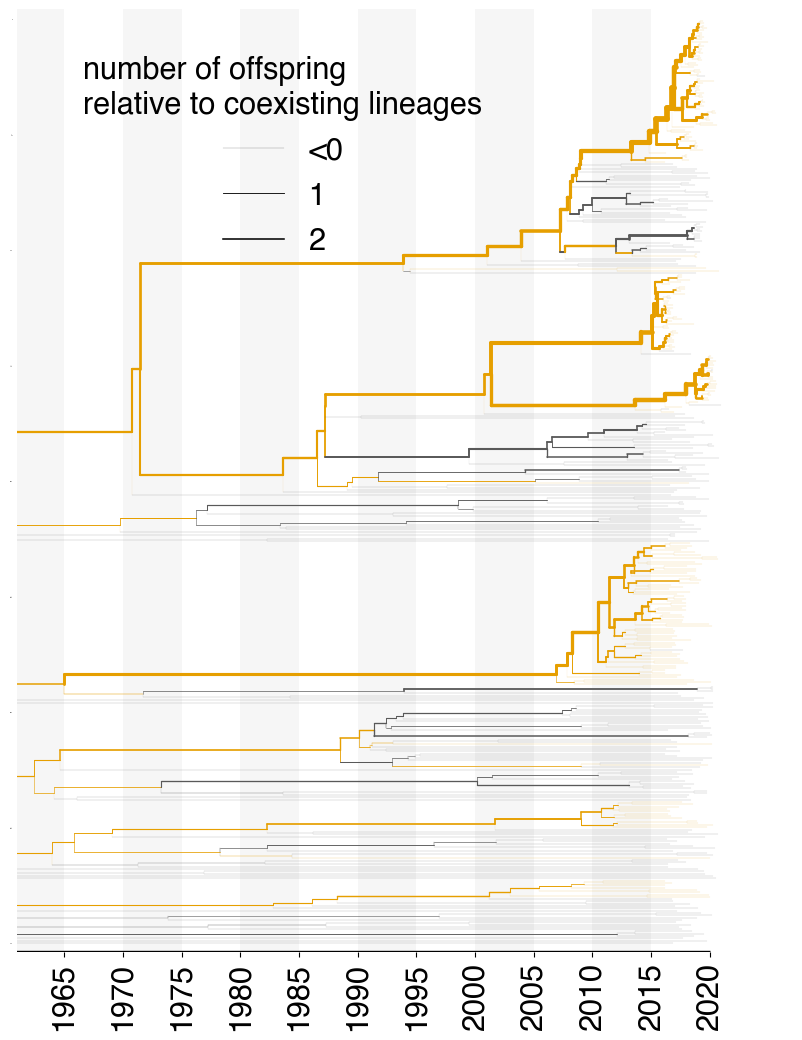

/Users/nmueller/Documents/github/Plasmids-Text/Figures/SonFlex_1_mapped.tree.pdf


In [5]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

# Function to plot line with varying linewidth
def plot_varying_linewidth(x, y, start_width, end_width, color):
    n = len(x)  # Number of points
    linewidths = np.linspace(start_width, end_width, n)  # Create varying linewidths

    for i in range(n-1):
        plt.plot(x[i:i+2], y[i:i+2], linewidth=linewidths[i], color=color)  # Plot each segment



fname= ['Sonnei3_1_mapped.tree','Sonnei1_1_mapped.tree','Sonnei1_1_mapped.tree','SonFlex_1_mapped.tree']
quantity = ['relativeClusterSize', 'relativeClusterSize', 'relativeClusterSize', 'relativeClusterSize']
zorderhighlight=3
# loop over seg2, seg3, seg4 with colors {seg2':"#0072B2",'seg3':"#009E73",'seg3':"#D55E00"}
colours={'seg2':"#0072B2",'seg3':"#009E73",'seg4':"#D55E00", 'seg1':"#E69F00"}
counter = 0
for segment in ['seg1','seg3', 'seg4', 'seg1']:
    # Define start and end colors in RGB
    start_color = "#595959"
    # define the end color based on the segment
    end_color = colours[segment]
    # make a continous color map for values from 0 to 1 that goes from start_color to end_color
    cmap_name = "custom_segment_cmap"
    
    # also define lower and upper bounds for the colormap
    cm = LinearSegmentedColormap.from_list(cmap_name, [start_color, end_color], N=2)
    tree_path=os.path.join(path,fname[counter])

    ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False,mostRecentSample="2020-12-01") ## load tree
    seg_count=0
    ll.drawTree()
    fig = plt.figure(figsize=(10, 15),facecolor='w') ## new figure
    gs = gridspec.GridSpec(2,2,height_ratios=[1,6],width_ratios=[1,4],wspace=0.2,hspace=0.1) 
    ax = plt.subplot(gs[1,0:],facecolor='w') ## first subplot - tree

    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines

    timewidth=5
    [ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.2,zorder = 0) for i in range(0,2020,2*timewidth)] ## add timeline

    lwscale=0.5

    for k in ll.Objects: ## iterate over branches
        x=k.absoluteTime
        xp=k.parent.absoluteTime
        y=k.y
        # round the segment value
        col=cm(round(k.traits[segment]))
        linewidth = max(k.traits.get(quantity[counter], 0.0),0.0)+0.25
        ax.plot([x,xp],[y,y],color=col,lw=lwscale*linewidth,zorder=zorderhighlight,solid_capstyle='round')

        if k.branchType=='node': ## if node - plot vertical bar
            left,right=k.children[-1].y,k.children[0].y  
            lw1 = lwscale*max(k.children[-1].traits.get(quantity[counter], 0.0), 0.1)
            lw0 = lwscale*max(k.children[0].traits.get(quantity[counter], 0.0), 0.1)

            col1=cm(round(k.children[-1].traits[segment])) ## get colour out of colour cycle
            col2=cm(round(k.children[-1].traits[segment])) ## get colour out of colour cycle
            ax.plot([x,x],[left,k.y],color=col1,lw=lw1,zorder=zorderhighlight,solid_capstyle='round')                
            ax.plot([x,x],[k.y,right],color=col2,lw=lw0,zorder=zorderhighlight,solid_capstyle='round')

    x_ticks = np.arange(1960, 2021, 5)  # Example: Ticks every 5 years from 1971 to 2027
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=90, ha="center")

                        
    ax.tick_params(axis='y',size=0,labelsize=0)
    # ax.tick_params(axis='x', size=0, labelsize=28, rotation=90)
    ax.set_ylim(ll.ySpan*1.01,-ll.ySpan*0.01)
    ax.set_xlim(1961,2027)

    ax.spines['bottom'].set_visible(False)

    # Draw a custom horizontal line for the x-axis between 1970 and 2020
    ax.hlines(y=ll.ySpan*1.009, xmin=1950, xmax=2020, colors='k', linestyles='-', lw=1)
    
    # Your existing color legend setup
    color_legend_handle = [Line2D([0], [0], color=cm(1.0), lw=4, label='Probability of segment presence')]

    # New part for line width legend
    # Simulate a few line widths for demonstration. Adjust these as needed.
    line_widths = [0.25, 1.25, 2.25]  # Example line widths
    line_widths = [lw * lwscale for lw in line_widths]  # Divide each width by 2.0
    line_width_labels = ['<0', '1', '2']  # Example labels corresponding to line widths
    line_width_legend_handles = [Line2D([0], [0], color='black', lw=lw, label=label) for lw, label in zip(line_widths, line_width_labels)]

    # Create the color bar for the segment presence probability
    norm = Normalize(vmin=0, vmax=1)  # Probability ranges from 0 to 1
    sm = ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])  # Set_array for ScalarMappable
    # Manually place the color bar just above the line width legend. Adjust the pad to position correctly

    # cb = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.005, pad=0)  
    # cb.set_label('', labelpad=0, rotation=0, fontsize=12, ha='center', va='bottom')
    # # Get the current position of the colorbar (it returns a Bbox object)
    # cb_pos = cb.ax.get_position()

    # # Modify the position parameters as needed (left, bottom, width, height)
    # # Example: Move the colorbar to the right inside the figure
    # new_pos = [cb_pos.x0 - 0.65, cb_pos.y0+0.23, cb_pos.width, cb_pos.height]

    # # Set the new position
    # cb.ax.set_position(new_pos)

    # # Assuming 'cb' is your colorbar object from which you can derive positions
    # cb_ax = cb.ax  # Get the colorbar's Axes object
    # cb_pos = cb_ax.get_position()  # Get the colorbar's position

    # # The top of the colorbar
    # cb_top = cb_pos.y1

    # To display both legends simultaneously, you need to create them and then add them back to the axis manually.
    # legend1 = ax.legend(handles=color_legend_handle, loc='upper left', bbox_to_anchor=(0.05, 0.95), title='Segment Presence Probability', frameon=False)
    # legend2 = ax.legend(handles=line_width_legend_handles, loc='upper left',  bbox_to_anchor=(cb_pos.x0+0.15, cb_top-0.01), title='', frameon=False)
    legend2 = ax.legend(handles=line_width_legend_handles, loc='upper left',  bbox_to_anchor=(0.05, 0.98), title='number of offspring\nrelative to coexisting lineages', frameon=False)
    
    plt.show()
    # use fname to save the figure, but replace _equal wiht the segment name
    figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/' + fname[counter].replace('equal', segment) + '.pdf' 
    print(figname)
    fig.savefig(figname, bbox_inches='tight')
    plt.close(fig)
    counter += 1


In [6]:
colours={'NC_007384':(0.2981622478541206, 0.44644367598435458, 0.64719724652229571),
        'NC_007385':"#E69F00",
        'NC_009345':"#0072B2",
        'NC_009346':"#009E73",
        'NC_009347':"#D55E00"}

segments=['NC_007384','NC_007385','NC_009345','NC_009346', 'NC_009347']
segment_name=['NC_007384','NC_007385','spA','spB', 'spC']

translate={i:segments.index(x) for i,x in enumerate(sorted(segments))}

def adjust_text_position(x, y, existing_positions, delta_x=1.25, delta_y=12):
    for ex, ey in existing_positions:
        if abs(x - ex) < delta_x*2 and abs(y - ey) < delta_y:
            if (x - ex) < 0:
                xnew = ex - delta_x  # Adjust x position to the left
            else:
                xnew = ex + delta_x  # Adjust x position to the right
            # Consider breaking the loop if a single adjustment is enough
            # Otherwise, remove the break to keep checking against all existing positions
            if not any(abs(xnew - ex) < delta_x and abs(y - ey) < delta_y for ex, ey in existing_positions):
                x=xnew
                break 
    return x, y

# Track positions where text has been plotted
plotted_positions = []

zorderhighlight=3
virus=['Sonnei_equal']
virusname=['Sonnei_equal']

linewidth=1

path='/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/'
fname= 'Sonnei_equal.network.tree'

tree_path=os.path.join(path,fname)
print(tree_path)

ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False,mostRecentSample="2020-12-01") ## load tree

seg_count=0
ll.drawTree()

fig = plt.figure(figsize=(10, 20),facecolor='w') ## new figure
# gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[1,4],wspace=0.1,hspace=0.1) 
gs = gridspec.GridSpec(2,2,height_ratios=[1,6],width_ratios=[1,4],wspace=0.2,hspace=0.1) 
ax=plt.subplot(gs[1,0:],facecolor='w') ## first subplot - tree

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines


colour_cycle = ["#595959", "#1c1c1c"]


# [ax.axvline(i,ls='-',color='lightgrey',lw=1,alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),1)] ## add timeline
timewidth=5
[ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.2,zorder = 0) for i in range(0,2020,2*timewidth)] ## add timeline

for k in ll.Objects:
    k.traits['re']=0

curr_traits_number = 0

for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
    if hasattr(k,'contribution'): ## if branch is the result of reassortment
        # pick a number at random between 0 and len(colour_cycle) that is not == w.traits['re']
        random_number = random.randint(0, len(colour_cycle) - 1)
        while random_number == k.traits['re']:
            random_number = random.randint(0, len(colour_cycle) - 1)

        subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
        for w in subtree: ## for every branch in subtree
            w.traits['re']=random_number

            
            #w.traits['re']=w.traits['re']+1 ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)


for k in ll.Objects: ## iterate over branches
    x=k.absoluteTime
    xp=k.parent.absoluteTime
    y=k.y

    if k.traits['seg4']=='true':
        col="#D55E00"
    else:
        col='#1c1c1c'

    if isinstance(k,bt.reticulation)==False: ## if a regular branch - colour based on number of reassortments from root
        ax.plot([x,xp],[y,y],color=col,lw=linewidth,zorder=zorderhighlight,solid_capstyle='round')
    else:
        ax.plot([x,xp],[y,y],color=col,lw=linewidth,ls='-',zorder=zorderhighlight,solid_capstyle='round') ## reassortment branches are black

    if k.branchType=='node': ## if node - plot vertical bar
        left,right=k.children[-1].y,k.children[0].y  
        
        col1=colour_cycle[k.children[-1].traits['re']%len(colour_cycle)] ## get colour out of colour cycle
        if k.children[-1].traits['seg4']=='true':
            col1="#D55E00"
        else:
            col1='#1c1c1c'
        if k.children[0].traits['seg4']=='true':
            col2="#D55E00"
        else:
            col2='#1c1c1c'



        # col2=colour_cycle[k.children[0].traits['re']%len(colour_cycle)] ## get colour out of colour cycle
        ax.plot([x,x],[left,k.y],color=col1,lw=linewidth,zorder=zorderhighlight,solid_capstyle='round')                
        ax.plot([x,x],[k.y,right],color=col2,lw=linewidth,zorder=zorderhighlight,solid_capstyle='round')

        
    elif isinstance(k,bt.leaf): ## if actual leaf - add circle
        # ax.scatter(x,y,s=20,facecolor=col,edgecolor='none',zorder=4)
        # ax.scatter(x,y,s=40,facecolor='k',edgecolor='none',zorder=3)
        #ax.plot([x,2024],[y,y],color='grey',lw=0.1,zorder=0)                

        # plot the presence/absence of a plasmid as a square
        for i in range(2, len(segments)):
            if i in k.traits['segments']:  # Checking if segment index is in the segments trait
                ax.scatter(2020 + i*0.5, y, s=8,marker='s',facecolor=colours[segments[i]], zorder=3)  # Corrected color name to 'black'

    elif isinstance(k,bt.reticulation): ## dealing with reassortant branch
        #if posteriorCutoff(k): ## passes posterior threshold
            segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)

            c='k'
            s=60
            for i in range(len(segs)):
                name=segments[translate[segs[i]]] ## get name of segment
                c=colours[name] ## get appropriate colour
                o=1/20.
                posterior_val = round(k.traits['posterior'],2)

                ax.plot([x+o*i,x+o*i],[y,k.target.y],color=c,lw=linewidth,ls='-',zorder=5,solid_capstyle='round') ## plot vertical lineage leaving donor and heading to recipient
                ax.scatter(x+o*i,k.target.y,s=s,facecolor=c,edgecolor='none',zorder=5)
                #ax.scatter(x+o*i,k.target.y,s=s,facecolor='k',edgecolor='none',zorder=5) ## plot circles
                if posterior_val>0.5:
                    adjusted_x, adjusted_y = adjust_text_position(x+o*i-0.25, k.target.y, plotted_positions)
                    # ax.text(adjusted_x, adjusted_y, posterior_val, ha="center", va="center", clip_on=True, zorder=6, rotation=90, fontsize='x-small', 
                            # bbox=dict(facecolor='white', alpha=0.01, edgecolor='none', boxstyle='round,pad=0'))
                    # plotted_positions.append((adjusted_x, adjusted_y))


for i in range(2, len(segments)):
    ax.plot([2020 + i * 0.5, 2022 + (i-3)*2], [-0.25,-4.25],color='k', lw=2,solid_capstyle='round')
    ax.text(2020 + (i-3)*2, -5.5, segment_name[i], ha="center", va="bottom", clip_on=True, fontsize='small', rotation=90)

x_ticks = np.arange(1960, 2021, 5)  # Example: Ticks every 5 years from 1971 to 2027
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=90, ha="center")

                    
ax.tick_params(axis='y',size=0,labelsize=0)
# ax.tick_params(axis='x', size=0, labelsize=28, rotation=90)
ax.set_ylim(ll.ySpan*1.01,-ll.ySpan*0.05)
ax.set_xlim(1961,2027)

ax.spines['bottom'].set_visible(False)

# Draw a custom horizontal line for the x-axis between 1970 and 2020
ax.hlines(y=ll.ySpan*1.009, xmin=1950, xmax=2020, colors='k', linestyles='-', lw=1)


plt.show()
figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/Calibration_Sonnei_equal.network.pdf'
print(figname)
fig.savefig(figname, bbox_inches='tight')
plt.close(fig)



/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/Sonnei_equal.network.tree


/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/visualisation_code/baltic_bacter.py:782: SyntaxWarning: invalid escape sequence '\('
  cerberus=re.match('(\(|,)([0-9]+)(\[|\:)',data[i-1:i+100]) ## look for tips in BEAST format (integers).
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/visualisation_code/baltic_bacter.py:789: SyntaxWarning: invalid escape sequence '\('
  cerberus=re.match('(\(|,)(\'|\")*([A-Za-z\_\-\|\.0-9\?\/ ]+)(\'|\"|)(\[)*',data[i-1:i+200])  ## look for tips with unencoded names - if the tips have some unusual format you'll have to modify this
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/visualisation_code/baltic_bacter.py:796: SyntaxWarning: invalid escape sequence '\)'
  cerberus=re.match('\)([0-9]+)\[',data[i-1:i+100]) ## look for multitype tree singletons.
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/visualisation_code/baltic_bacter.py:802: 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella2024/combined/Sonnei_equal.network.tree'

0
/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella/combined/SonFlex_equal.network.tree
[]
10
207.0


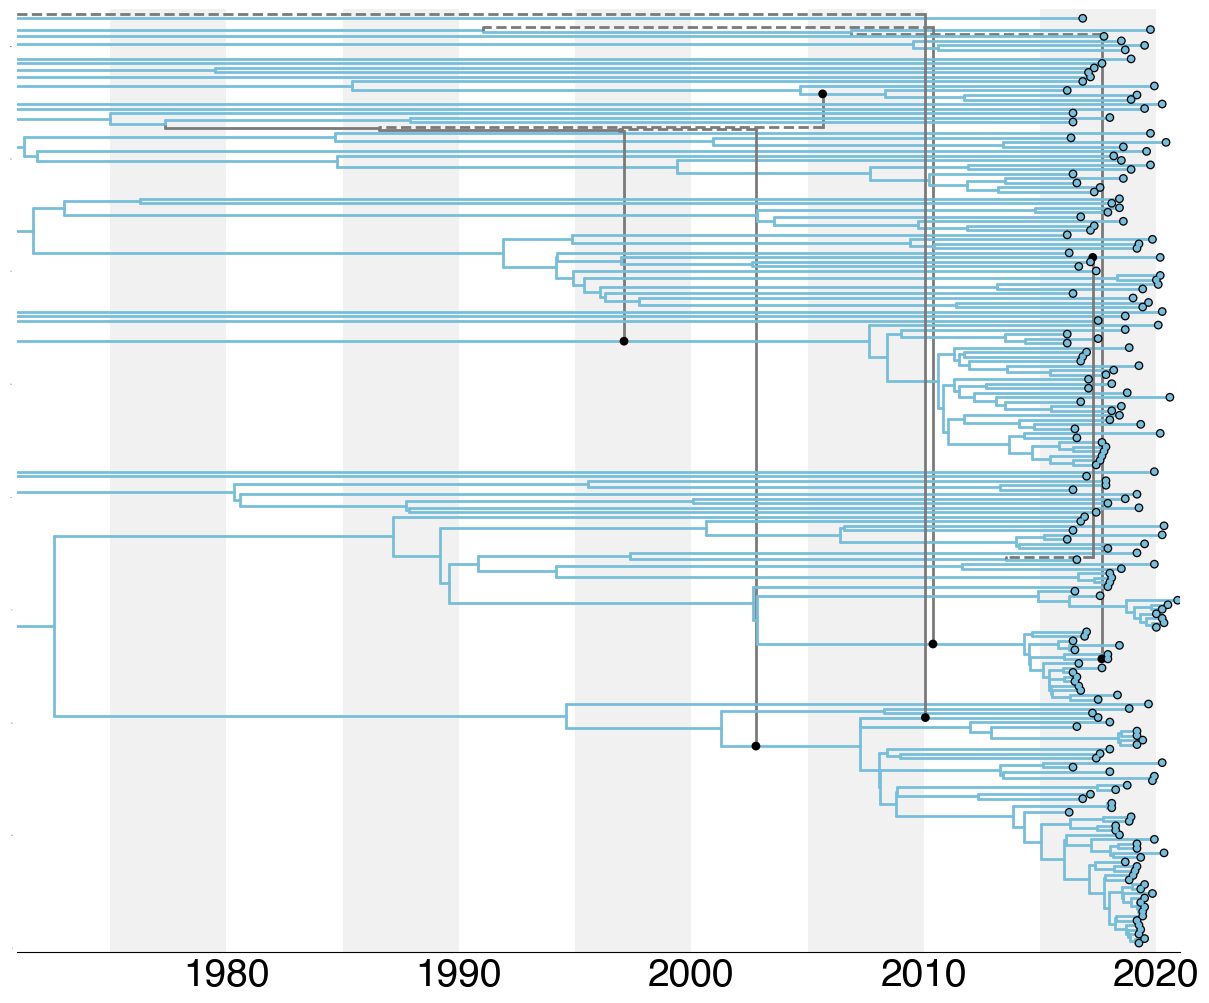

207.0


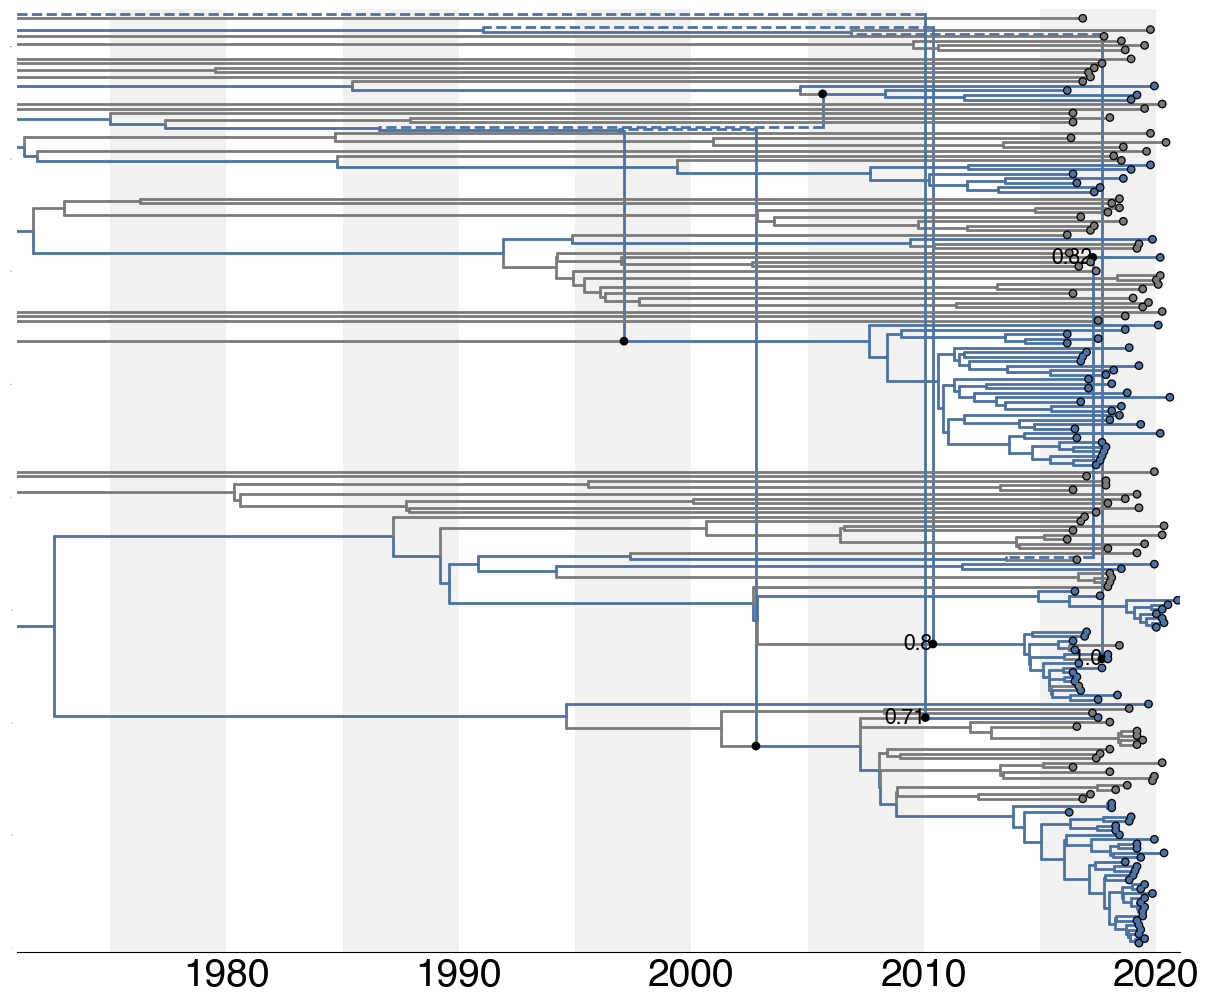

In [ ]:
segments=['NC_007384','LN624486']
translate={i:segments.index(x) for i,x in enumerate(sorted(segments))}

colourSwitches=[mpl.cm.Greys(i) for i in np.linspace(0.4,0.8,3)]

colours={'NC_007384':(0.4666666666666667, 0.7450980392156863, 0.8588235294117647),
        'LN624486':(0.2981622478541206, 0.44644367598435458, 0.64719724652229571)}
         
virus=['SonFlex_equal']
virusname=['SonFlex_equal']


for v in range(len(virus)):
    print(v)

    path='/Users/nmueller/Documents/github/Plasmids-Material/Applications/Shigella/combined/'
    fname= virusname[v] + '.network.tree'

    tree_path=os.path.join(path,fname)
    print(tree_path)

    ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False,mostRecentSample="2020-12-01") ## load tree
    
    seg_count=0
    for seg in segments:
        ll.drawTree()

        fig = plt.figure(figsize=(15, 15),facecolor='w') ## new figure
        # gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[1,4],wspace=0.1,hspace=0.1) 
        gs = gridspec.GridSpec(2,2,height_ratios=[1,6],width_ratios=[1,4],wspace=0.2,hspace=0.1) 

        ax=plt.subplot(gs[1,0:],facecolor='w') ## first subplot - tree

        # for i in range(len(colours)):
        #     seg=segments[i]
        #     ax.text(0.05,0.75-i/23.0,seg,size=42,color=colours[seg],transform=ax.transAxes,fontdict={'family':'Arial'}) ## plot segment colour legend

        #posteriorCutoff=lambda k: k.traits['posterior']>0.0 ## define cutoff for removing reassortment events

        #keep=set(list(filter(posteriorCutoff,ll.getBranches(lambda k: isinstance(k,bt.reticulation))))+ll.getExternal(lambda k: isinstance(k,bt.leaf))) ## remove reassortment at a given cutoff

        #ll=ll.reduceTree(keep) ## reduce tree down to those that pass posterior cutoff
        linewidth=2

        for k in ll.Objects:
            k.traits['re']=0

        for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
            if hasattr(k,'contribution'): ## if branch is the result of reassortment
                subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
                for w in subtree: ## for every branch in subtree
                    #if posteriorCutoff(k.contribution): ## if it's a branch that passes a posterior threshold
                        w.traits['re']=max([w.traits['re']+1,k.contribution.traits['re']+1]) ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)

        for k in ll.Objects: ## iterate over branches
            x=k.absoluteTime
            xp=k.parent.absoluteTime
            y=k.y
            if k.traits['seg'+str(seg_count)]=="true":
                col=colours[seg]
            else:
                col=colourSwitches[1]


            #col=colourSwitches[k.traits['re']%len(colourSwitches)] ## colour cycles through range defined at the beginning
        #     mostReassortments=max([w.traits['re'] for w in ll.Objects if 're' in w.traits])
        #     norm=mpl.colors.Normalize(-mostReassortments/3,mostReassortments)
        #     col=mpl.cm.Greys(norm(k.traits['re']))
        #                 print(col)

            if isinstance(k,bt.reticulation)==False: ## if a regular branch - colour based on number of reassortments from root
                ax.plot([x,xp],[y,y],color=col,lw=linewidth,zorder=1,solid_capstyle='round')
            else:
                ax.plot([x,xp],[y,y],color=col,lw=linewidth,ls='--',zorder=1,solid_capstyle='round') ## reassortment branches are black

            if k.branchType=='node': ## if node - plot vertical bar
                left,right=k.children[-1].y,k.children[0].y
                
                if k.children[-1].traits['seg'+str(seg_count)]=="true":
                    col1=colours[seg]
                else:
                    col1=colourSwitches[1]

                    
                if k.children[0].traits['seg'+str(seg_count)]=="true":
                    col2=colours[seg]
                else:
                    col2=colourSwitches[1]
                
                ax.plot([x,x],[left,k.y],color=col1,lw=linewidth,zorder=1,solid_capstyle='round')                
                ax.plot([x,x],[k.y,right],color=col2,lw=linewidth,zorder=1,solid_capstyle='round')

                
            elif isinstance(k,bt.leaf): ## if actual leaf - add circle
                ax.scatter(x,y,s=20,facecolor=col,edgecolor='none',zorder=4)
                ax.scatter(x,y,s=40,facecolor='k',edgecolor='none',zorder=3)

            elif isinstance(k,bt.reticulation): ## dealing with reassortant branch
                #if posteriorCutoff(k): ## passes posterior threshold
                    segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)

                    c='k'
                    s=20
                    for i in range(len(segs)):
                        name=segments[translate[segs[i]]] ## get name of segment
                        c=colours[name] ## get appropriate colour
                        o=1/20.
                        posterior_val = round(k.traits['posterior'],2)

                        ax.plot([x+o*i,x+o*i],[y,k.target.y],color=col,lw=linewidth,ls='-',zorder=1) ## plot vertical lineage leaving donor and heading to recipient
                        ax.scatter(x+o*i,k.target.y,s=s,facecolor='k',edgecolor='none',zorder=3) ## plot circles
                        ax.scatter(x+o*i,k.target.y,s=s*2,facecolor='k',edgecolor='none',zorder=2)
                        if k.traits['seg'+str(seg_count)]=="true" and posterior_val>0.5:
                            ax.text(x+o*i, k.target.y, posterior_val,ha="right", va="center",clip_on=True,fontsize='x-small')

        [ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines
        # [ax.axvline(i,ls='-',color='lightgrey',lw=1,alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),1)] ## add timeline
        timewidth=5
        [ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.3, zorder=0) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),2*timewidth)] ## add timeline

        ax.tick_params(axis='y',size=0,labelsize=0)
        ax.tick_params(axis='x',size=0,labelsize=28)
        print(ll.ySpan)
        ax.set_ylim(-1,ll.ySpan+1)
        ax.set_xlim(1971,2021)

        plt.show()
        figname =  '/Users/nmueller/Documents/github/Plasmids-Text/Figures/' + virusname[v] +'.' +seg + '.pdf'
        fig.savefig(figname, bbox_inches='tight')
        plt.close(fig)
        seg_count=seg_count+1